# The (heterosegmented) group contribution PC-SAFT functional
In segment-based Helmholtz energy functionals like the one corresponding to the heterosegmented gc PC-SAFT equation of state, the spatial distribution of individual segments is calculated.

In [1]:
from feos.si import *
from feos.dft import *
from feos.gc_pcsaft import *

import matplotlib.pyplot as plt

## Interfaces
In this example, the vapor-liquid interface of pure 1-pentanol is calculated. From the density profile, it becomes apparent how the polar hydroxy group slightly accumulates on the liquid side of the interface.

In [2]:
parameters = GcPcSaftFunctionalParameters.from_json_segments(
    ['1-pentanol'], 
    '../parameters/pcsaft/gc_substances.json', 
    '../parameters/pcsaft/sauer2014_hetero.json'
)
func = HelmholtzEnergyFunctional.gc_pcsaft(parameters)
vle = PhaseEquilibrium.pure(func, 300*KELVIN)
profile = PlanarInterface.from_tanh(vle, 4096, 100*ANGSTROM, 600*KELVIN).solve()

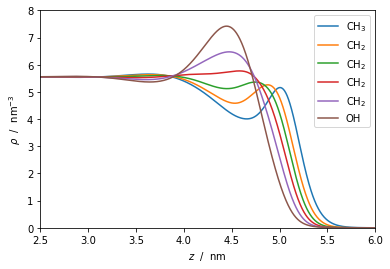

In [3]:
f, ax = plt.subplots()

ax.plot(profile.z/(NANO*METER), (profile.density*NAV*(NANO*METER)**3).T)
ax.legend(['CH$_3$'] + ['CH$_2$']*4 + ['OH'])
ax.set_xlabel('$z~~/~~\mathrm{nm}$')
ax.set_ylabel('$\\rho~~/~~\mathrm{nm}^{-3}$')
ax.axis([2.5,6,0,8]);

## Porous media
The orientation of polar molecules becomes even more apparent in confined media. Shown here, the orientation of 1-pentanol in a non-polar slit pore.

In [4]:
bulk = State(func, 300*KELVIN, pressure=5*BAR)
solver = DFTSolver().picard_iteration(tol=1e-5, damping_coefficient=0.05).anderson_mixing()
pore = Pore1D(
    Geometry.Cartesian, 
    20*ANGSTROM, 
    ExternalPotential.LJ93(3.0, 10.0, 0.08)
).initialize(bulk).solve(solver)

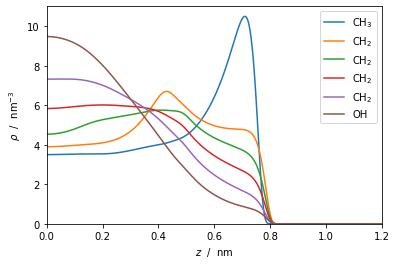

In [5]:
f, ax = plt.subplots()

ax.plot(pore.z/(NANO*METER), (pore.density*NAV*(NANO*METER)**3).T)
ax.legend(['CH$_3$'] + ['CH$_2$']*4 + ['OH'])
ax.set_xlabel('$z~~/~~\mathrm{nm}$')
ax.set_ylabel('$\\rho~~/~~\mathrm{nm}^{-3}$')
ax.axis([0,1.2,0,11]);

## Branched molecules
The heterosegmented DFT method is able to describe branched molecules. Note how the isomers 1-propanol and 2-propanol show significantly different orientations in a slit pore.

Due to the symmetry of the 2-propanol molecules, only 3 distinct density profiles are visible.

In [6]:
def calc_pore(comp):
    parameters = GcPcSaftFunctionalParameters.from_json_segments(
        [comp], 
        '../parameters/pcsaft/gc_substances.json', 
        '../parameters/pcsaft/sauer2014_hetero.json'
    )
    func = HelmholtzEnergyFunctional.gc_pcsaft(parameters)
    bulk = State(func, 300*KELVIN, pressure=5*BAR)
    solver = DFTSolver().picard_iteration(tol=1e-5, damping_coefficient=0.05).anderson_mixing()
    return Pore1D(
        Geometry.Cartesian, 
        20*ANGSTROM, 
        ExternalPotential.LJ93(3.0, 10.0, 0.08)
    ).initialize(bulk).solve(solver)

comps = ['2-propanol', '1-propanol']
pores = [calc_pore(comp) for comp in comps]

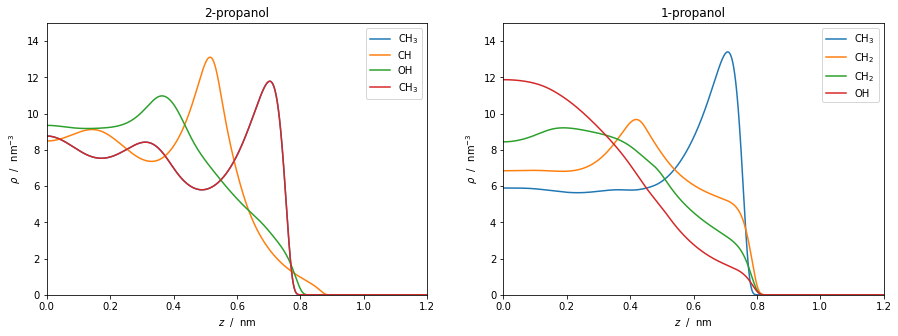

In [7]:
f, axes = plt.subplots(1,2,figsize=(15,5))

for pore,comp,ax in zip(pores,comps,axes):
    ax.plot(pore.z/(NANO*METER), (pore.density*NAV*(NANO*METER)**3).T)
    if comp[0] == '2':
        ax.legend(['CH$_3$', 'CH', 'OH', 'CH$_3$'])
    elif comp[0] == '1':
        ax.legend(['CH$_3$'] + ['CH$_2$']*2 + ['OH'])
    ax.set_xlabel('$z~~/~~\mathrm{nm}$')
    ax.set_ylabel('$\\rho~~/~~\mathrm{nm}^{-3}$')
    ax.axis([0,1.2,0,15])
    ax.set_title(comp)